<a href="https://colab.research.google.com/github/MariamKotob/ML2-notebook/blob/master/CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

### imports

In [1]:
!pip -q install pydot_ng > /dev/null 2>&1
!pip -q install graphviz > /dev/null 2>&1
!apt install graphviz > /dev/null 2>&1

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display
%matplotlib inline

### 2D Convolution

create a function conv2d that performs a 2D Convolution on an input grayscale image (2D numpy array) with a given 2D kernel

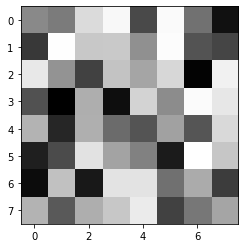

In [2]:
rand_img = np.random.uniform(size=[8, 8])
rand_kernel = np.random.uniform(size=[3, 3])
plt.imshow(rand_img, cmap='gray')

In [11]:
def conv2d(img, kernel):
    #Your code goes here
    out_img = np.zeros([ (img.shape[0]-kernel.shape[0]+1), (img.shape[1]-kernel.shape[1]+1) ])
    for i in range(out_img.shape[0]):
      for j in range(out_img.shape[1]):
        out_img[i, j] = np.sum( np.multiply( kernel, img[i:i+kernel.shape[0], j:j+kernel.shape[1]]))
    return out_img

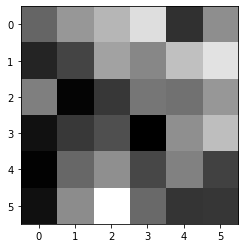

In [12]:
convoluted_img = conv2d(rand_img, rand_kernel)
plt.imshow(convoluted_img, cmap='gray')

Now add the padding and stride:

In [23]:
def conv2d(img, kernel, padding=0, stride=1):
    #Your code goes here
    out_img = np.zeros([ 
                        (img.shape[0]-kernel.shape[0]+1+2*padding) // stride, 
                        (img.shape[1]-kernel.shape[1]+1+2*padding) // stride 
                        ])
    #padded_img = np.zeros([ (img.shape[0]+2*padding), (img.shape[1]+2*padding) ])
    #padded_img[padding:-padding , padding:-padding] = rand_img
    padded_img = np.pad(img, padding, 'constant')
    k, l = 0, 0
    for i in range(out_img.shape[0]):
      for j in range(out_img.shape[1]):
        out_img[i, j] = np.sum( np.multiply( kernel, padded_img[k:k+kernel.shape[0], l:l+kernel.shape[1]]))
        l += stride 
      k += stride
      l = 0
    return out_img

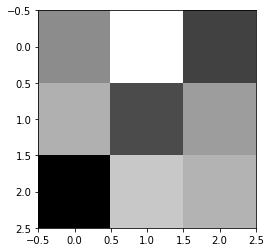

In [24]:
convoluted_img = conv2d(rand_img, rand_kernel, padding=0, stride=2)
plt.imshow(convoluted_img, cmap='gray')

Now adjust the hyperparameters using the sliders on the right and see how the output shape changes



Input shape: (10, 10, 3)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

The output dimension is: [4, 4, 1]
The number of parameters is: 28


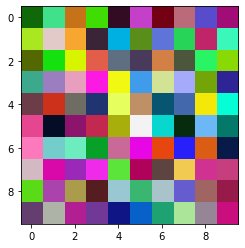

In [27]:
#@title Convolutional layer parameters {run: "auto"}
filters = 0  #@param { type: "slider", min:0, max: 10, step: 1 }
kernel_size = 3 #@param { type: "slider", min:1, max: 10, step: 1 }
stride = 2 #@param { type: "slider", min:1, max: 3, step: 1 }

# Create a random colour "image" of shape 10x10 with a depth of 3 (for red, green and blue)
dummy_input = np.random.uniform(size=[10, 10, 3])
fig, ax = plt.subplots(1, 1)
plt.imshow(dummy_input)
ax.grid(False)
print('Input shape: {}'.format(dummy_input.shape))

conv_layer = tf.keras.layers.Conv2D(
    filters=filters,
    kernel_size=kernel_size,
    strides=stride,
    padding="valid",
    input_shape=[10, 10, 3])

# Convert the image to a tensor and add an extra batch dimension which
# the convolutional layer expects.
input_tensor = tf.convert_to_tensor(dummy_input[None, :, :, :])
convoluted = conv_layer(input_tensor)

print('The output dimension is: {}'.format(list(convoluted.shape)[1:]))
print('The number of parameters is: {}'.format(conv_layer.count_params()))

### Pooling

Create a function called max_pool that performs a max pooling operation on a given image with a given kernel size and a given stride

In [33]:
def max_pool(image, kernel_size=2, stride=2):
    #Your code goes here
    out_img = np.zeros([ 
                        1+ (image.shape[0]-kernel_size) // stride, 
                        1+ (image.shape[1]-kernel_size) // stride 
                        ])
    k, l = 0, 0
    for i in range(out_img.shape[0]):
      for j in range(out_img.shape[1]):
        out_img[i, j] = np.max( image[k:k+kernel_size, l:l+kernel_size])
        l += stride 
      k += stride
      l = 0
    return out_img

Now compare the results with the MaxPooling2D from tf.keras

In [34]:
X = np.array([[9, 5, 4, 5, 6, 4],
              [6, 6, 3, 5, 8, 2],
              [4, 6, 9, 1, 3, 6],
              [9, 7, 1, 5, 8, 1],
              [4, 9, 9, 5, 7, 3],
              [7, 3, 6, 4, 9, 1]])

print(max_pool(X, kernel_size=2, stride=2))

max_pool_layer = tf.keras.layers.MaxPooling2D((2, 2), strides=2)
max_pool_layer(tf.convert_to_tensor(X[None, :, :, None])).numpy().squeeze()

[[9. 5. 8.]
 [9. 9. 8.]
 [9. 9. 9.]]


array([[9, 5, 8],
       [9, 9, 8],
       [9, 9, 9]])

### Custom keras Layers

With tf.keras we can create custom layers using the subclassing of tf.keras.layes.Layer. For example, to build a custom dense layer:

In [48]:
class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    self.kernel = self.add_weight("kernel",
                                  shape = [int(input_shape[-1]), 
                                           self.num_outputs])
  
  def call(self, input):
    return tf.matmul(input, self.kernel)

layer = MyDenseLayer(10)

Now create a ResNet block using the subclassing method


In [50]:
class ResNetBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(ResNetBlock, self).__init__(name='')

    self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size)
    self.bn1 = tf.keras.layers.BatchNormalization()

    self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size)
    self.bn2 = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training = False):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = tf.nn.relu(x) 

    x = self.conv2(x)
    x = self.bn2(x)
    x += input_tensor 
    return tf.nn.relu(x)

In [53]:
block = ResNetBlock(1, 3)
_ = block(tf.zeros([1, 3, 3, 3]))
block.summary()

Model: "res_net_block_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            multiple                  12        
_________________________________________________________________
batch_normalization_4 (Batch multiple                  12        
_________________________________________________________________
conv2d_8 (Conv2D)            multiple                  12        
_________________________________________________________________
batch_normalization_5 (Batch multiple                  12        
Total params: 48
Trainable params: 36
Non-trainable params: 12
_________________________________________________________________


### How to build models with tf.keras

1. Sequential API

In [60]:
my_model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(1, (1,1), input_shape=(None, None, 3)),
                                tf.keras.layers.BatchNormalization(),
                                tf.keras.layers.Conv2D(1, (1,1)),
                                ResNetBlock(1, 3)
                                ])
for i in range(2):
  my_model.add(ResNetBlock(1, 3))

In [61]:
my_model(tf.zeros([1, 2, 3, 3]))
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, None, None, 1)     4         
_________________________________________________________________
batch_normalization_10 (Batc (None, None, None, 1)     4         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, None, None, 1)     2         
_________________________________________________________________
res_net_block_4 (ResNetBlock (None, None, None, 3)     42        
_________________________________________________________________
res_net_block_5 (ResNetBlock (None, None, None, 3)     48        
_________________________________________________________________
res_net_block_6 (ResNetBlock (None, None, None, 3)     48        
Total params: 148
Trainable params: 110
Non-trainable params: 38
_______________________________________________________

2. Functional API

In [62]:
def minigooglenet_functional(width, height, depth, classes):
	def conv_module(x, K, kX, kY, stride, chanDim, padding="same"):
		# define a CONV => BN => RELU pattern
		x = Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Activation("relu")(x)
		# return the block
		return x

	def inception_module(x, numK1x1, numK3x3, chanDim):
		# define two CONV modules, then concatenate across the
		# channel dimension
		conv_1x1 = conv_module(x, numK1x1, 1, 1, (1, 1), chanDim)
		conv_3x3 = conv_module(x, numK3x3, 3, 3, (1, 1), chanDim)
		x = concatenate([conv_1x1, conv_3x3], axis=chanDim)
		# return the block
		return x

	def downsample_module(x, K, chanDim):
		# define the CONV module and POOL, then concatenate
		# across the channel dimensions
		conv_3x3 = conv_module(x, K, 3, 3, (2, 2), chanDim,
			padding="valid")
		pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
		x = concatenate([conv_3x3, pool], axis=chanDim)
		# return the block
		return x
	
	# initialize the input shape to be "channels last" and the
	# channels dimension itself
	inputShape = (height, width, depth)
	chanDim = -1
	# define the model input and first CONV module
	inputs = Input(shape=inputShape)
	x = conv_module(inputs, 96, 3, 3, (1, 1), chanDim)
	# two Inception modules followed by a downsample module
	x = inception_module(x, 32, 32, chanDim)
	x = inception_module(x, 32, 48, chanDim)
	x = downsample_module(x, 80, chanDim)
	# four Inception modules followed by a downsample module
	x = inception_module(x, 112, 48, chanDim)
	x = inception_module(x, 96, 64, chanDim)
	x = inception_module(x, 80, 80, chanDim)
	x = inception_module(x, 48, 96, chanDim)
	x = downsample_module(x, 96, chanDim)
	# two Inception modules followed by global POOL and dropout
	x = inception_module(x, 176, 160, chanDim)
	x = inception_module(x, 176, 160, chanDim)
	x = AveragePooling2D((7, 7))(x)
	x = Dropout(0.5)(x)
	# softmax classifier
	x = Flatten()(x)
	x = Dense(classes)(x)
	x = Activation("softmax")(x)
	# create the model
	model = Model(inputs, x, name="minigooglenet")
	# return the constructed network architecture
	return model

3. Model Subclassing

In [64]:
class MiniVGGNetModel(tf.keras.Model):
	def __init__(self, classes, chanDim=-1):
		# call the parent constructor
		super(MiniVGGNetModel, self).__init__()
		
		# initialize the layers in the first (CONV => RELU) * 2 => POOL
		# layer set
		self.conv1A = Conv2D(32, (3, 3), padding="same")
		self.act1A = Activation("relu")
		self.bn1A = BatchNormalization(axis=chanDim)
		self.conv1B = Conv2D(32, (3, 3), padding="same")
		self.act1B = Activation("relu")
		self.bn1B = BatchNormalization(axis=chanDim)
		self.pool1 = MaxPooling2D(pool_size=(2, 2))
		
		# initialize the layers in the second (CONV => RELU) * 2 => POOL
		# layer set
		self.conv2A = Conv2D(32, (3, 3), padding="same")
		self.act2A = Activation("relu")
		self.bn2A = BatchNormalization(axis=chanDim)
		self.conv2B = Conv2D(32, (3, 3), padding="same")
		self.act2B = Activation("relu")
		self.bn2B = BatchNormalization(axis=chanDim)
		self.pool2 = MaxPooling2D(pool_size=(2, 2))
		
		# initialize the layers in our fully-connected layer set
		self.flatten = Flatten()
		self.dense3 = Dense(512)
		self.act3 = Activation("relu")
		self.bn3 = BatchNormalization()
		self.do3 = Dropout(0.5)
		
		# initialize the layers in the softmax classifier layer set
		self.dense4 = Dense(classes)
		self.softmax = Activation("softmax")
  
	
	
	def call(self, inputs):
		# build the first (CONV => RELU) * 2 => POOL layer set
		x = self.conv1A(inputs)
		x = self.act1A(x)
		x = self.bn1A(x)
		x = self.conv1B(x)
		x = self.act1B(x)
		x = self.bn1B(x)
		x = self.pool1(x)
		
		# build the second (CONV => RELU) * 2 => POOL layer set
		x = self.conv2A(x)
		x = self.act2A(x)
		x = self.bn2A(x)
		x = self.conv2B(x)
		x = self.act2B(x)
		x = self.bn2B(x)
		x = self.pool2(x)
		
		# build our FC layer set
		x = self.flatten(x)
		x = self.dense3(x)
		x = self.act3(x)
		x = self.bn3(x)
		x = self.do3(x)
		
		# build the softmax classifier
		x = self.dense4(x)
		x = self.softmax(x)
		
		# return the constructed model
		return x